In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

2024-08-10 11:49:44.171615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 11:49:44.579984: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


Validation Member: 0251
Testing Member: 0261
Training Members: ['0161']
loading data & saving
made it!
0


2024-08-10 11:50:29.946261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


219/219 [==============================] - 1s 1ms/step
1
219/219 [==============================] - 0s 1ms/step
2
219/219 [==============================] - 0s 1ms/step
3
219/219 [==============================] - 0s 1ms/step
4
219/219 [==============================] - 0s 1ms/step
5
219/219 [==============================] - 0s 857us/step
6
219/219 [==============================] - 1s 2ms/step
7
219/219 [==============================] - 0s 1ms/step
8
219/219 [==============================] - 0s 1ms/step
9
219/219 [==============================] - 0s 2ms/step


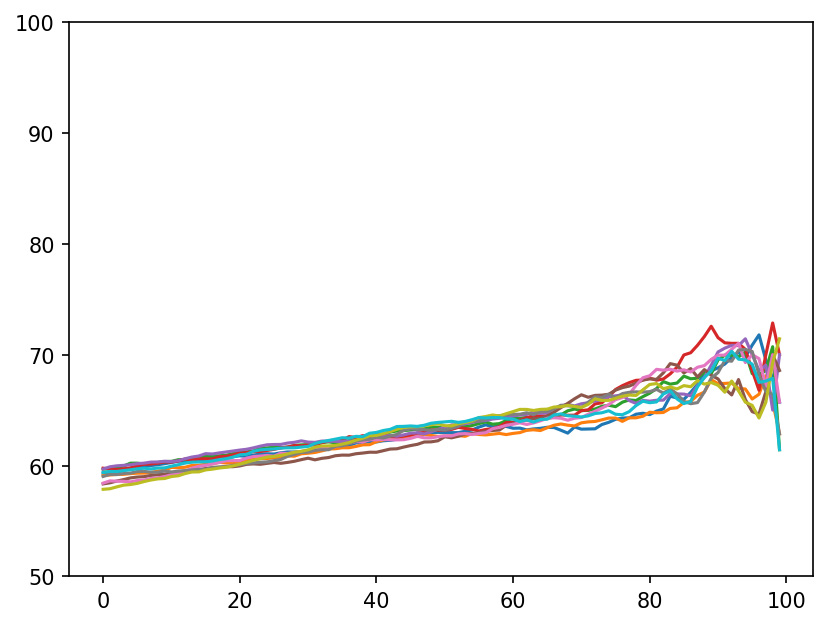

Training Members: ['0161', '0171']
loading data & saving
0
210/210 [==============================] - 0s 849us/step
1
210/210 [==============================] - 0s 1ms/step
2
210/210 [==============================] - 0s 899us/step
3
210/210 [==============================] - 0s 1ms/step
4
210/210 [==============================] - 0s 1ms/step
5
210/210 [==============================] - 0s 743us/step
6
210/210 [==============================] - 0s 741us/step
7
210/210 [==============================] - 0s 778us/step
8
210/210 [==============================] - 0s 1ms/step
9
210/210 [==============================] - 0s 1ms/step


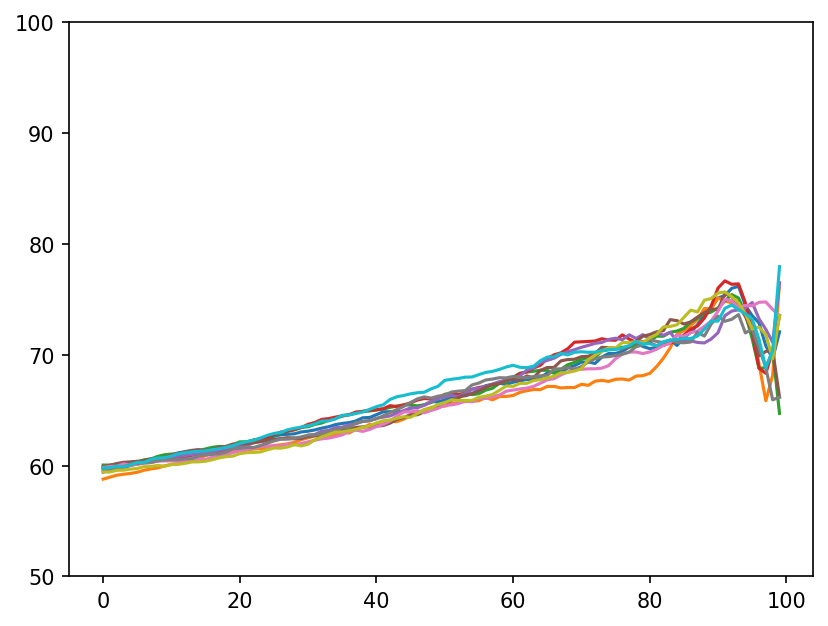

Training Members: ['0161', '0171', '0181']
loading data & saving
0
215/215 [==============================] - 1s 2ms/step
1
215/215 [==============================] - 0s 2ms/step
2
215/215 [==============================] - 0s 2ms/step
3
215/215 [==============================] - 0s 2ms/step
4
215/215 [==============================] - 1s 2ms/step
5
215/215 [==============================] - 1s 2ms/step
6
215/215 [==============================] - 1s 2ms/step
7
215/215 [==============================] - 0s 1ms/step
8
215/215 [==============================] - 0s 2ms/step
9
215/215 [==============================] - 0s 1ms/step


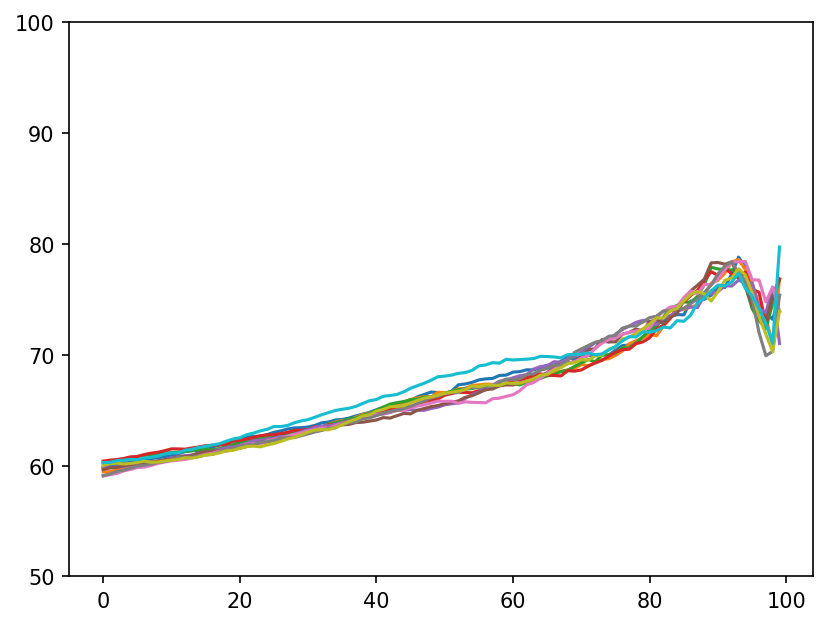

Training Members: ['0161', '0171', '0181', '0191']
loading data & saving
0
221/221 [==============================] - 0s 2ms/step
1
221/221 [==============================] - 0s 1ms/step
2
221/221 [==============================] - 0s 1ms/step
3
221/221 [==============================] - 0s 1ms/step
4
221/221 [==============================] - 0s 1ms/step
5
221/221 [==============================] - 0s 1ms/step
6
221/221 [==============================] - 0s 1ms/step
7
221/221 [==============================] - 0s 1ms/step
8
221/221 [==============================] - 0s 1ms/step
9
221/221 [==============================] - 0s 1ms/step


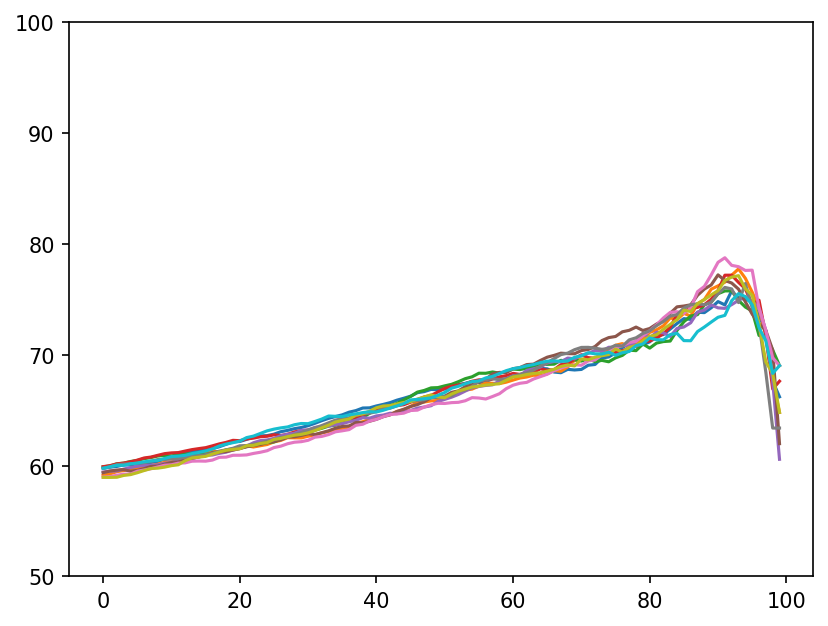

Training Members: ['0161', '0171', '0181', '0191', '0201']
loading data & saving
0
227/227 [==============================] - 0s 1ms/step
1
227/227 [==============================] - 0s 1ms/step
2
227/227 [==============================] - 0s 1ms/step
3
227/227 [==============================] - 0s 1ms/step
4
227/227 [==============================] - 0s 1ms/step
5
227/227 [==============================] - 0s 1ms/step
6
227/227 [==============================] - 0s 1ms/step
7
227/227 [==============================] - 0s 1ms/step
8
227/227 [==============================] - 0s 1ms/step
9
227/227 [==============================] - 0s 1ms/step


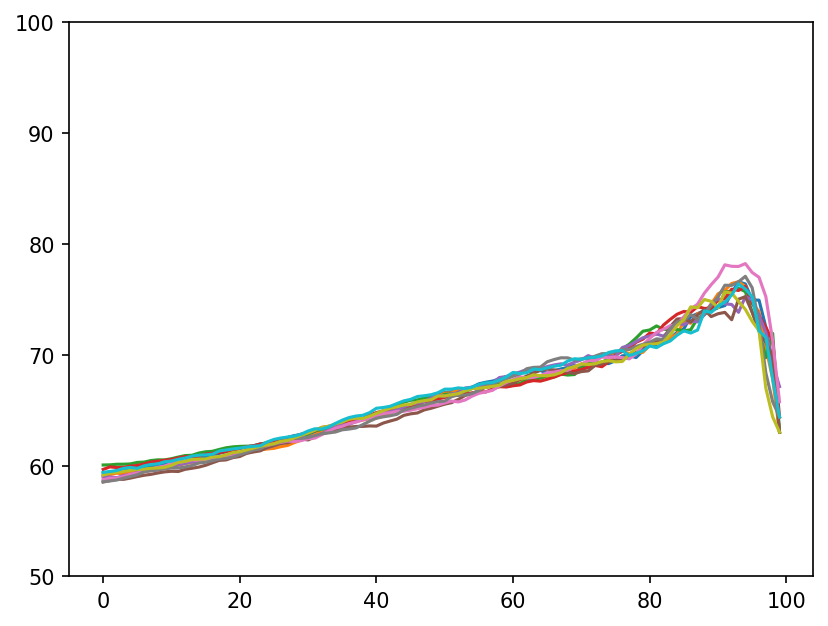

Training Members: ['0161', '0171', '0181', '0191', '0201', '0211']
loading data & saving
0
228/228 [==============================] - 0s 1ms/step
1
228/228 [==============================] - 0s 1ms/step
2
228/228 [==============================] - 0s 1ms/step
3
228/228 [==============================] - 0s 1ms/step
4
228/228 [==============================] - 0s 1ms/step
5
228/228 [==============================] - 0s 1ms/step
6
228/228 [==============================] - 0s 1ms/step
7
228/228 [==============================] - 0s 2ms/step
8
228/228 [==============================] - 0s 2ms/step
9
228/228 [==============================] - 0s 2ms/step


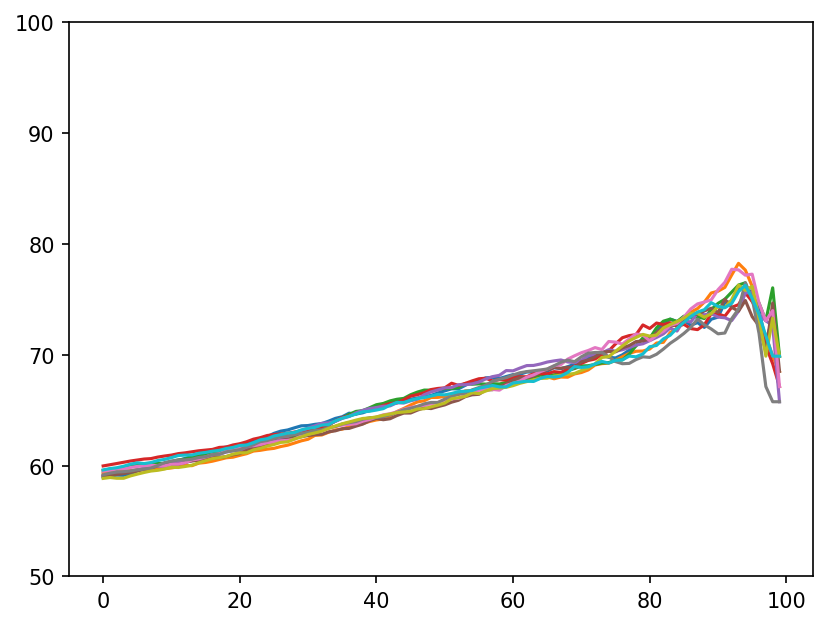

Training Members: ['0161', '0171', '0181', '0191', '0201', '0211', '0221']
loading data & saving
0
228/228 [==============================] - 0s 1ms/step
1
228/228 [==============================] - 0s 1ms/step
2
228/228 [==============================] - 0s 1ms/step
3
228/228 [==============================] - 0s 1ms/step
4
228/228 [==============================] - 0s 2ms/step
5
228/228 [==============================] - 0s 2ms/step
6
228/228 [==============================] - 1s 2ms/step
7
228/228 [==============================] - 1s 2ms/step
8
228/228 [==============================] - 1s 2ms/step
9
228/228 [==============================] - 0s 2ms/step


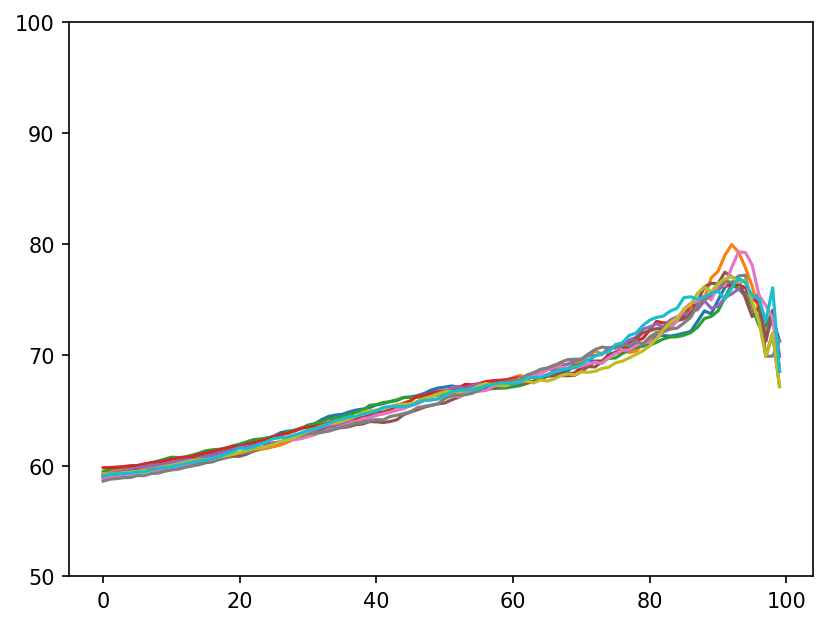

Training Members: ['0161', '0171', '0181', '0191', '0201', '0211', '0221', '0231']
loading data & saving
0
230/230 [==============================] - 0s 2ms/step
1
230/230 [==============================] - 0s 2ms/step
2
230/230 [==============================] - 0s 2ms/step
3
230/230 [==============================] - 0s 2ms/step
4
230/230 [==============================] - 0s 2ms/step
5
230/230 [==============================] - 0s 1ms/step
6
230/230 [==============================] - 0s 1ms/step
7
230/230 [==============================] - 0s 1ms/step
8
230/230 [==============================] - 0s 1ms/step
9
230/230 [==============================] - 0s 1ms/step


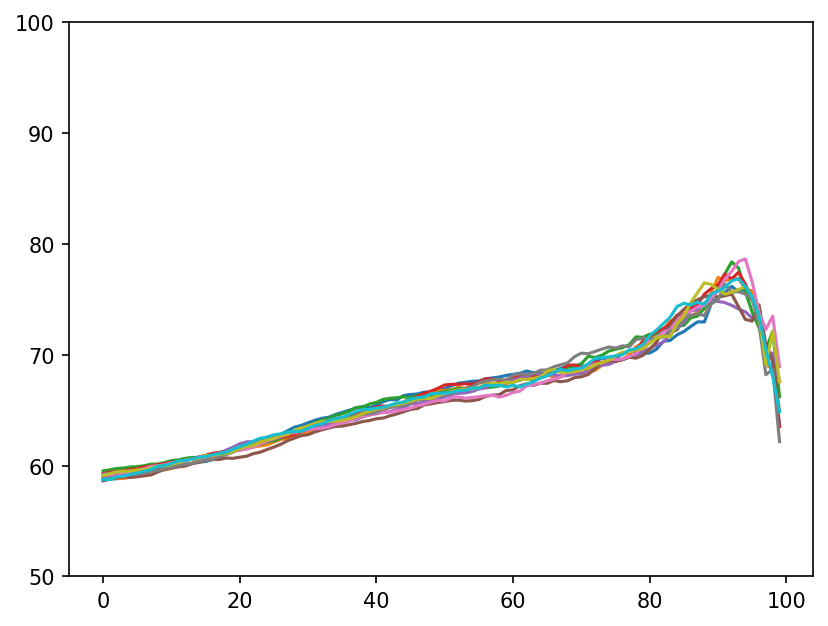

Training Members: ['0161', '0171', '0181', '0191', '0201', '0211', '0221', '0231', '0241']
loading data & saving
0
232/232 [==============================] - 1s 2ms/step
1
232/232 [==============================] - 1s 2ms/step
2
232/232 [==============================] - 0s 1ms/step
3
232/232 [==============================] - 0s 1ms/step
4
232/232 [==============================] - 0s 1ms/step
5
232/232 [==============================] - 0s 1ms/step
6
232/232 [==============================] - 0s 1ms/step
7
232/232 [==============================] - 1s 2ms/step
8
232/232 [==============================] - 0s 2ms/step
9
232/232 [==============================] - 0s 2ms/step


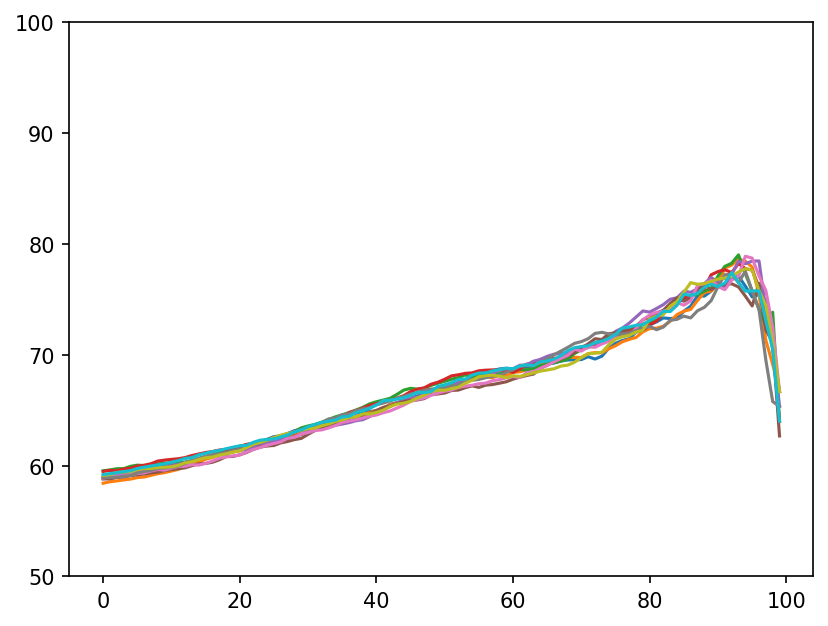

Validation Member: 0261
Testing Member: 0271
Training Members: ['0171']
loading data & saving
made it!
0
208/208 [==============================] - 0s 1ms/step
1
208/208 [==============================] - 0s 1ms/step
2
208/208 [==============================] - 0s 1ms/step
3
208/208 [==============================] - 0s 2ms/step
4
208/208 [==============================] - 0s 1ms/step
5
208/208 [==============================] - 0s 1ms/step
6
208/208 [==============================] - 0s 1ms/step
7
208/208 [==============================] - 0s 1ms/step
8
208/208 [==============================] - 0s 1ms/step
9
208/208 [==============================] - 0s 1ms/step


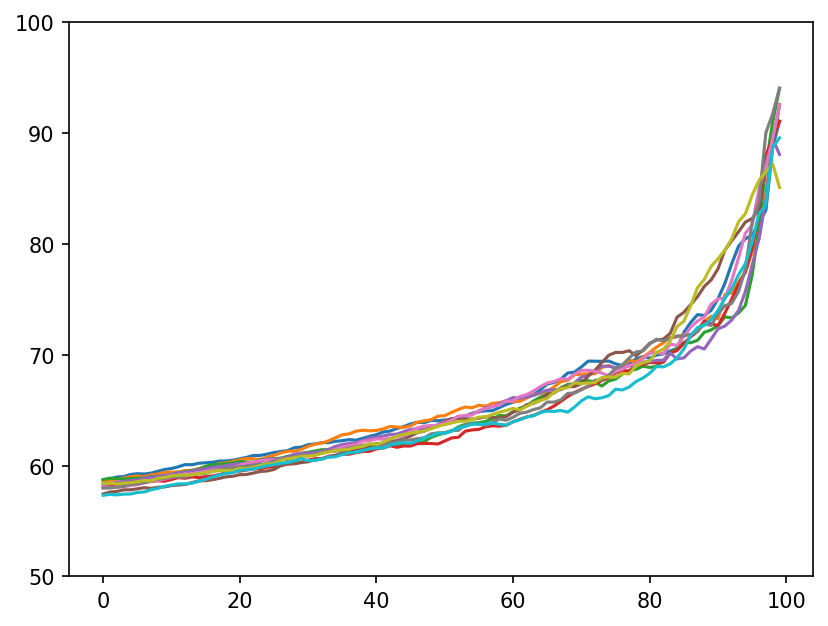

Training Members: ['0171', '0181']
loading data & saving
0
222/222 [==============================] - 0s 1ms/step
1
222/222 [==============================] - 0s 1ms/step
2
222/222 [==============================] - 0s 1ms/step
3
222/222 [==============================] - 0s 1ms/step
4
222/222 [==============================] - 0s 1ms/step
5
222/222 [==============================] - 0s 1ms/step
6
222/222 [==============================] - 0s 1ms/step
7
222/222 [==============================] - 0s 2ms/step
8
222/222 [==============================] - 0s 2ms/step
9
222/222 [==============================] - 0s 1ms/step


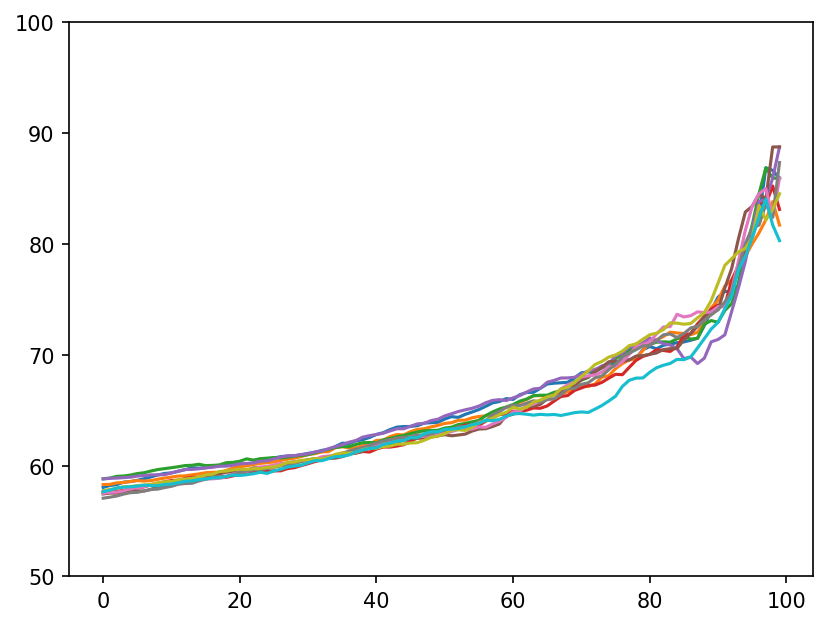

Training Members: ['0171', '0181', '0191']
loading data & saving
0
230/230 [==============================] - 0s 1ms/step
1
230/230 [==============================] - 0s 1ms/step
2
230/230 [==============================] - 0s 1ms/step
3
230/230 [==============================] - 0s 1ms/step
4
230/230 [==============================] - 0s 1ms/step
5
230/230 [==============================] - 0s 1ms/step
6
230/230 [==============================] - 0s 1ms/step
7
230/230 [==============================] - 0s 1ms/step
8
230/230 [==============================] - 0s 1ms/step
9
230/230 [==============================] - 0s 2ms/step


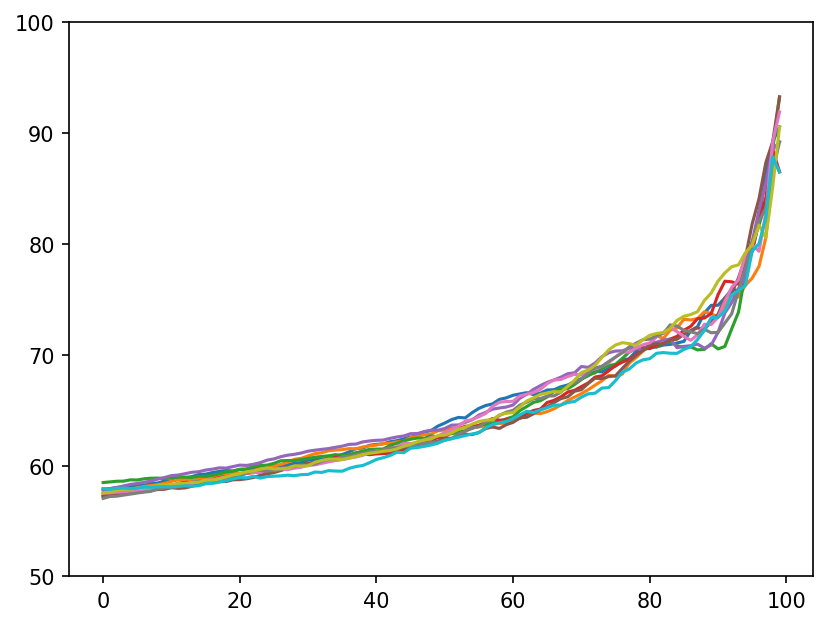

Training Members: ['0171', '0181', '0191', '0201']
loading data & saving
0
239/239 [==============================] - 0s 1ms/step
1
239/239 [==============================] - 0s 1ms/step
2
239/239 [==============================] - 0s 1ms/step
3
239/239 [==============================] - 0s 1ms/step
4
239/239 [==============================] - 0s 1ms/step
5
239/239 [==============================] - 0s 1ms/step
6
239/239 [==============================] - 0s 2ms/step
7
239/239 [==============================] - 1s 2ms/step
8
239/239 [==============================] - 1s 2ms/step
9
239/239 [==============================] - 1s 2ms/step


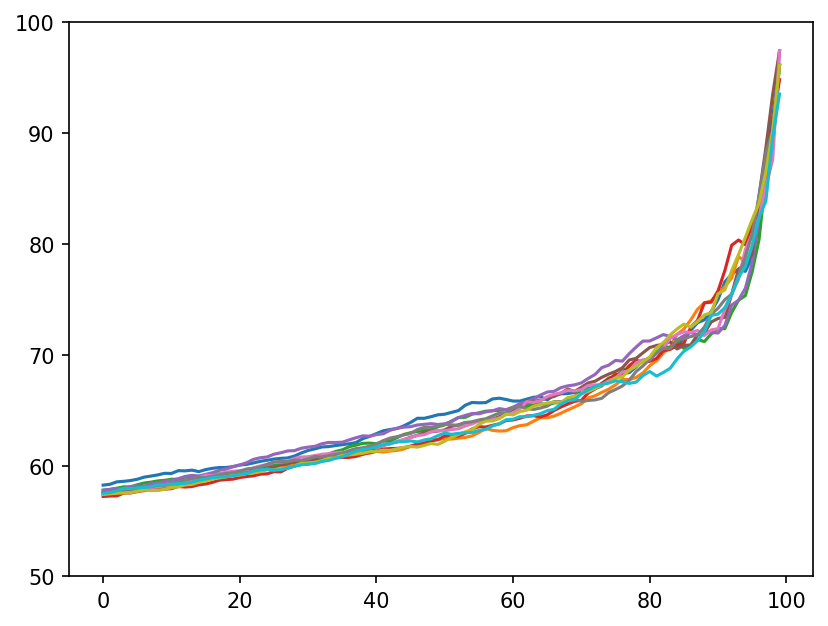

Training Members: ['0171', '0181', '0191', '0201', '0211']
loading data & saving
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 2ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 1ms/step
6
240/240 [==============================] - 0s 1ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 0s 1ms/step
9
240/240 [==============================] - 0s 1ms/step


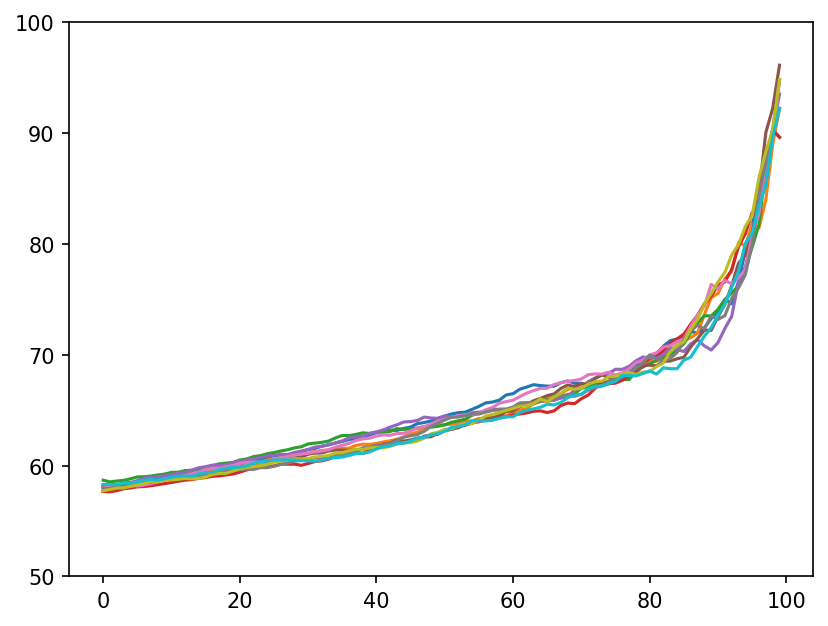

Training Members: ['0171', '0181', '0191', '0201', '0211', '0221']
loading data & saving
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 1ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 2ms/step
6
240/240 [==============================] - 0s 1ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 1s 2ms/step
9
240/240 [==============================] - 1s 2ms/step


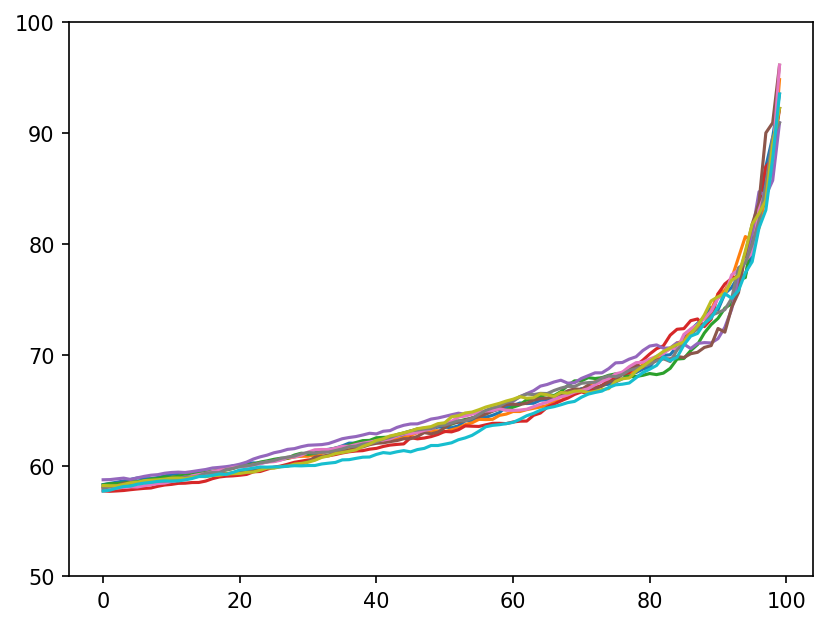

Training Members: ['0171', '0181', '0191', '0201', '0211', '0221', '0231']
loading data & saving
0
241/241 [==============================] - 1s 2ms/step
1
241/241 [==============================] - 1s 2ms/step
2
241/241 [==============================] - 1s 2ms/step
3
241/241 [==============================] - 1s 2ms/step
4
241/241 [==============================] - 0s 1ms/step
5
241/241 [==============================] - 0s 1ms/step
6
241/241 [==============================] - 0s 1ms/step
7
241/241 [==============================] - 0s 1ms/step
8
241/241 [==============================] - 0s 1ms/step
9
241/241 [==============================] - 0s 1ms/step


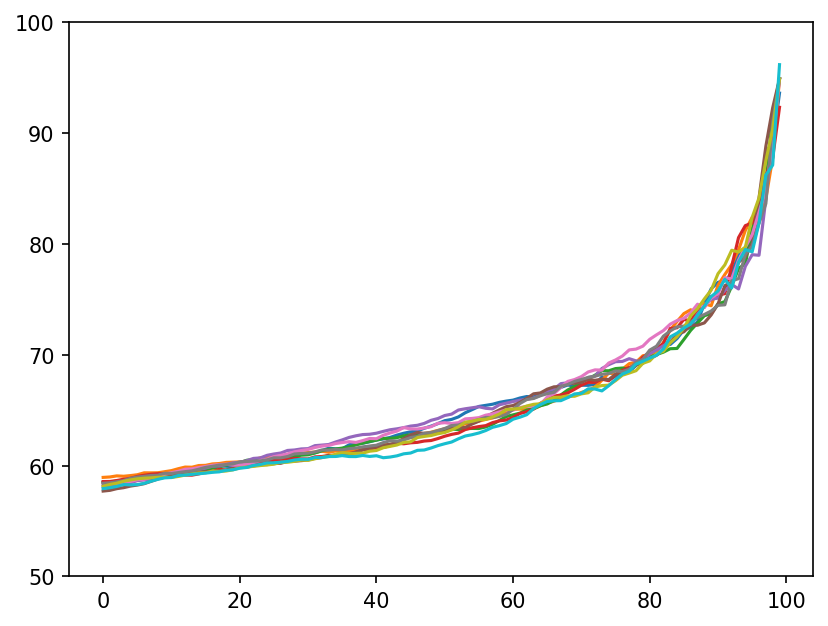

Training Members: ['0171', '0181', '0191', '0201', '0211', '0221', '0231', '0241']
loading data & saving
0
243/243 [==============================] - 0s 1ms/step
1
243/243 [==============================] - 1s 2ms/step
2
243/243 [==============================] - 1s 2ms/step
3
243/243 [==============================] - 1s 2ms/step
4
243/243 [==============================] - 0s 1ms/step
5
243/243 [==============================] - 0s 1ms/step
6
243/243 [==============================] - 0s 1ms/step
7
243/243 [==============================] - 0s 1ms/step
8
243/243 [==============================] - 0s 1ms/step
9
243/243 [==============================] - 0s 803us/step


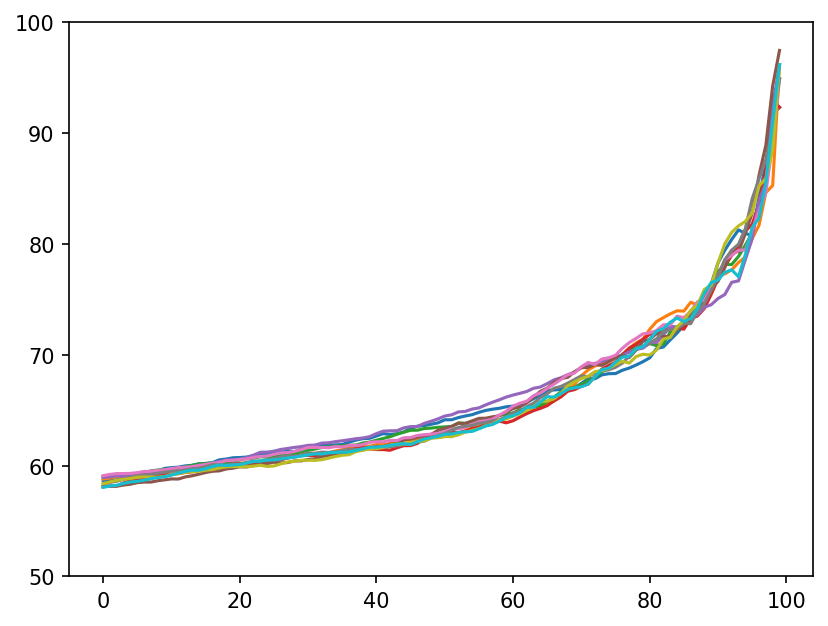

Training Members: ['0171', '0181', '0191', '0201', '0211', '0221', '0231', '0241', '0251']
loading data & saving
0
239/239 [==============================] - 0s 1ms/step
1
239/239 [==============================] - 0s 1ms/step
2
239/239 [==============================] - 0s 1ms/step
3
239/239 [==============================] - 0s 1ms/step
4
239/239 [==============================] - 0s 1ms/step
5
239/239 [==============================] - 0s 1ms/step
6
239/239 [==============================] - 0s 1ms/step
7
239/239 [==============================] - 0s 1ms/step
8
239/239 [==============================] - 0s 1ms/step
9
239/239 [==============================] - 0s 1ms/step


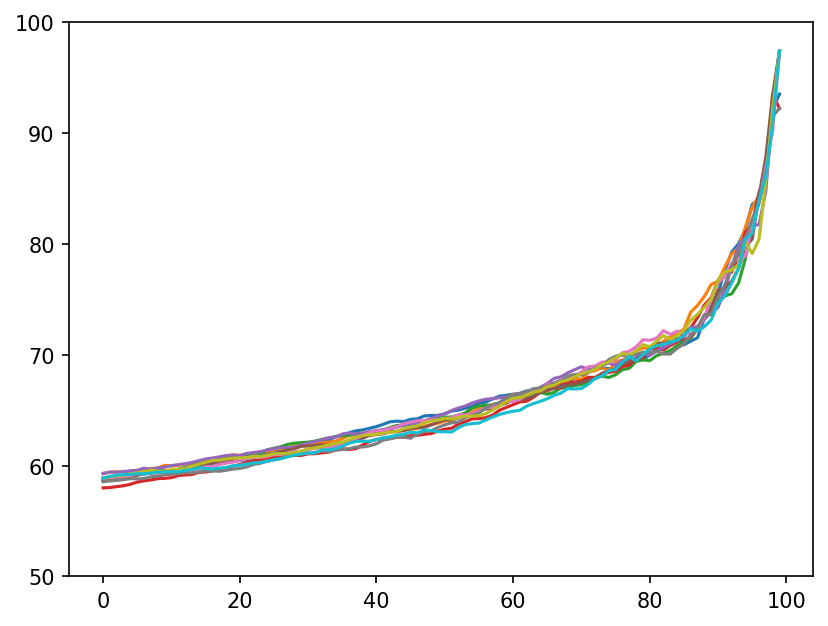

Validation Member: 0271
Testing Member: 0281
Training Members: ['0181']
loading data & saving
made it!
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 1ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 1ms/step
6
240/240 [==============================] - 0s 1ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 0s 1ms/step
9
240/240 [==============================] - 0s 1ms/step


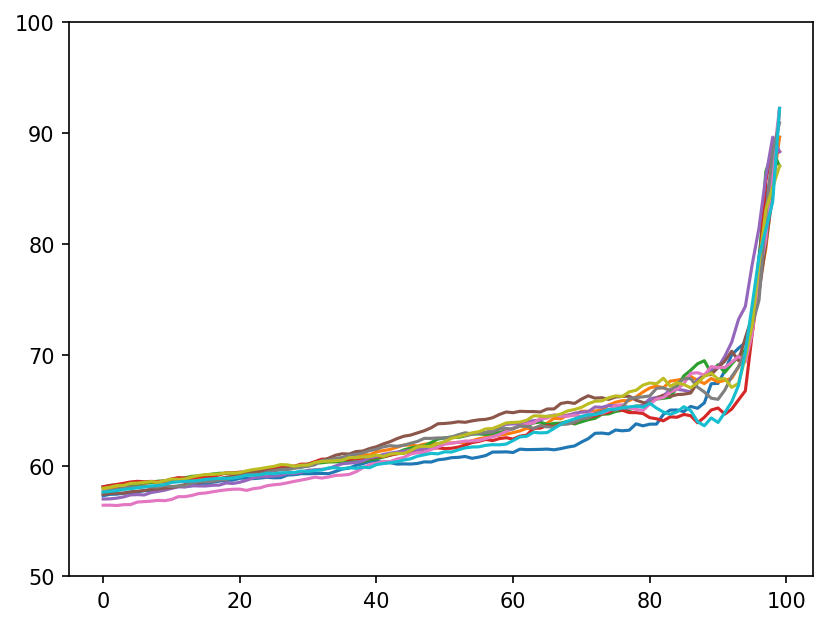

Training Members: ['0181', '0191']
loading data & saving
0
242/242 [==============================] - 0s 1ms/step
1
242/242 [==============================] - 0s 1ms/step
2
242/242 [==============================] - 0s 1ms/step
3
242/242 [==============================] - 0s 1ms/step
4
242/242 [==============================] - 0s 1ms/step
5
242/242 [==============================] - 0s 1ms/step
6
242/242 [==============================] - 0s 1ms/step
7
242/242 [==============================] - 0s 1ms/step
8
242/242 [==============================] - 0s 1ms/step
9
242/242 [==============================] - 0s 1ms/step


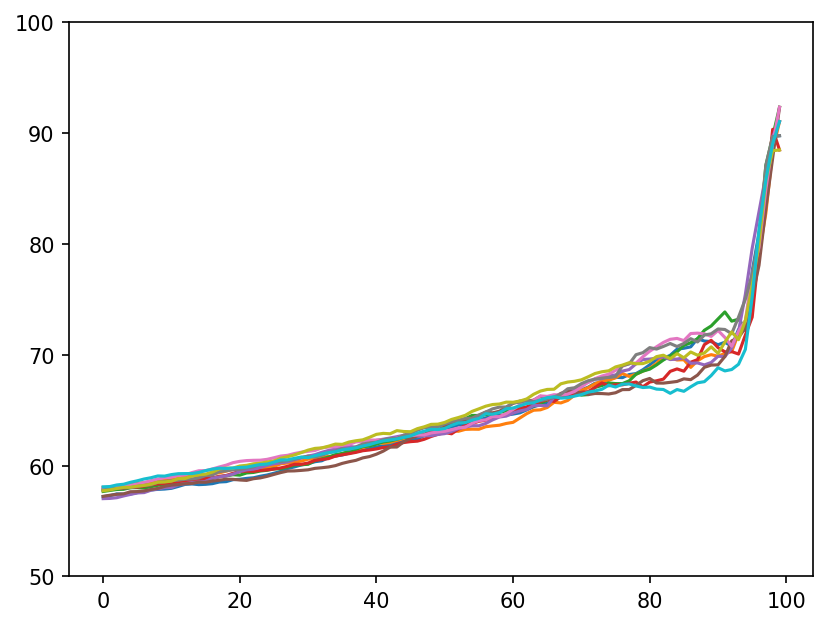

Training Members: ['0181', '0191', '0201']
loading data & saving
0
236/236 [==============================] - 0s 1ms/step
1
236/236 [==============================] - 0s 1ms/step
2
236/236 [==============================] - 0s 1ms/step
3
236/236 [==============================] - 0s 1ms/step
4
236/236 [==============================] - 0s 1ms/step
5
236/236 [==============================] - 0s 1ms/step
6
236/236 [==============================] - 0s 1ms/step
7
236/236 [==============================] - 0s 1ms/step
8
236/236 [==============================] - 0s 1ms/step
9
236/236 [==============================] - 0s 1ms/step


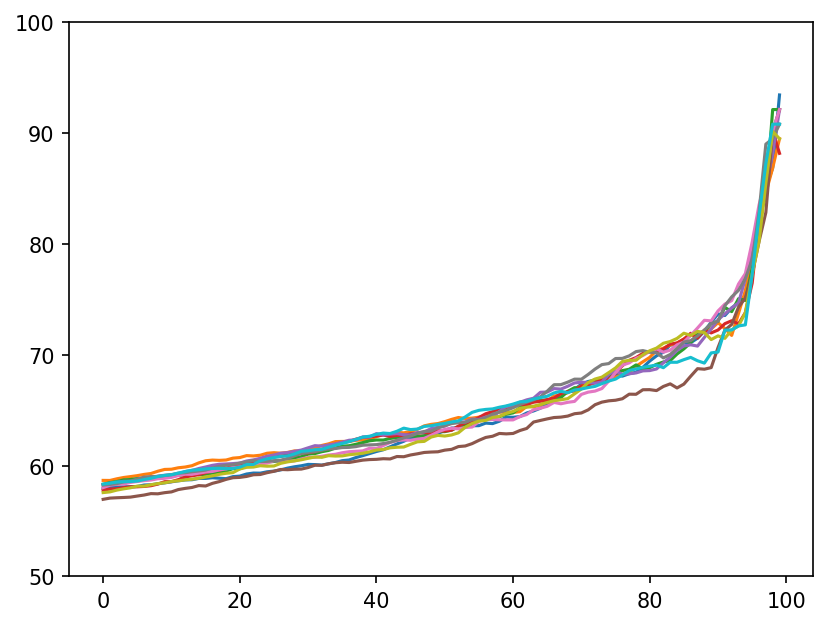

Training Members: ['0181', '0191', '0201', '0211']
loading data & saving
0
237/237 [==============================] - 0s 1ms/step
1
237/237 [==============================] - 0s 1ms/step
2
237/237 [==============================] - 0s 1ms/step
3
237/237 [==============================] - 0s 1ms/step
4
237/237 [==============================] - 0s 1ms/step
5
237/237 [==============================] - 0s 1ms/step
6
237/237 [==============================] - 0s 2ms/step
7
237/237 [==============================] - 0s 1ms/step
8
237/237 [==============================] - 0s 1ms/step
9
237/237 [==============================] - 0s 1ms/step


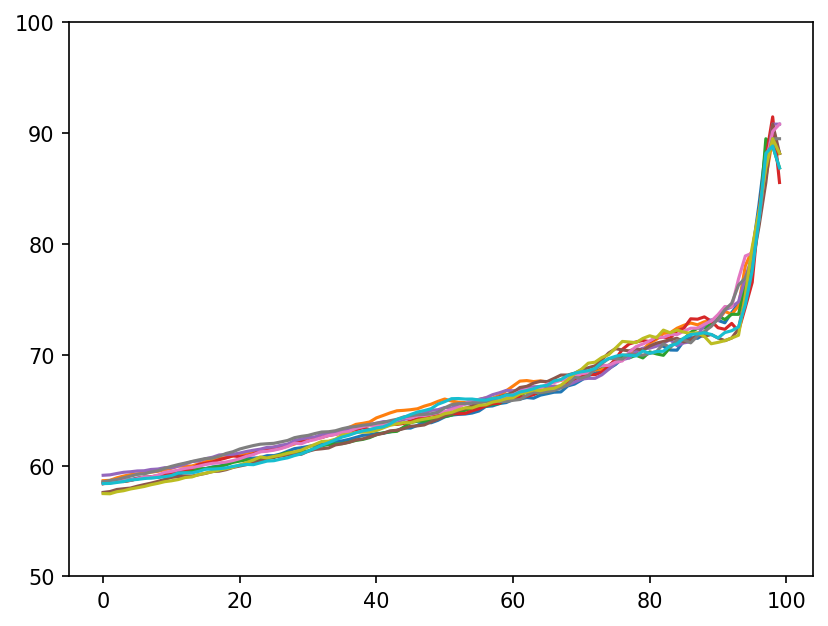

Training Members: ['0181', '0191', '0201', '0211', '0221']
loading data & saving
0
239/239 [==============================] - 0s 1ms/step
1
239/239 [==============================] - 0s 1ms/step
2
239/239 [==============================] - 0s 1ms/step
3
239/239 [==============================] - 0s 1ms/step
4
239/239 [==============================] - 0s 1ms/step
5
239/239 [==============================] - 0s 1ms/step
6
239/239 [==============================] - 0s 1ms/step
7
239/239 [==============================] - 0s 1ms/step
8
239/239 [==============================] - 0s 1ms/step
9
239/239 [==============================] - 0s 1ms/step


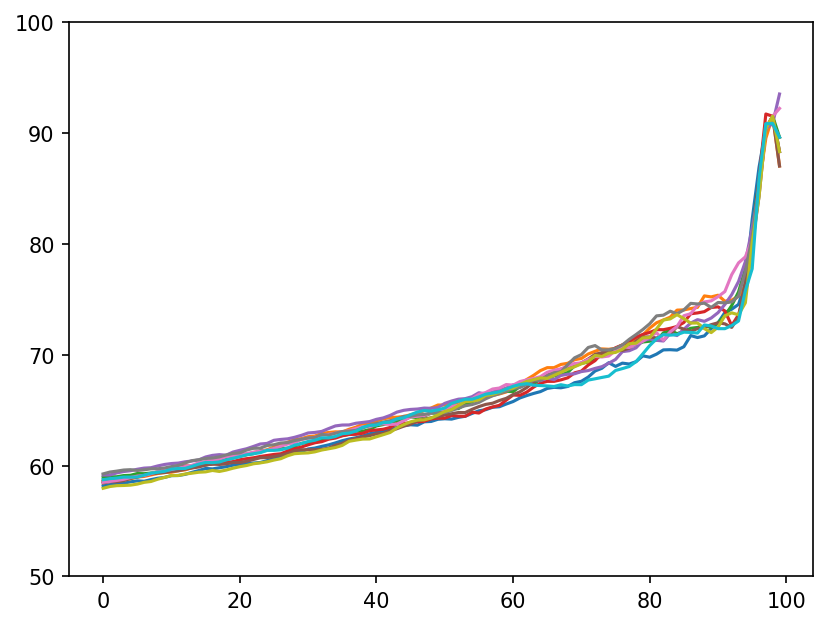

Training Members: ['0181', '0191', '0201', '0211', '0221', '0231']
loading data & saving
0
238/238 [==============================] - 0s 1ms/step
1
238/238 [==============================] - 0s 1ms/step
2
238/238 [==============================] - 0s 1ms/step
3
238/238 [==============================] - 0s 1ms/step
4
238/238 [==============================] - 0s 1ms/step
5
238/238 [==============================] - 0s 1ms/step
6
238/238 [==============================] - 0s 1ms/step
7
238/238 [==============================] - 0s 1ms/step
8
238/238 [==============================] - 0s 1ms/step
9
238/238 [==============================] - 0s 1ms/step


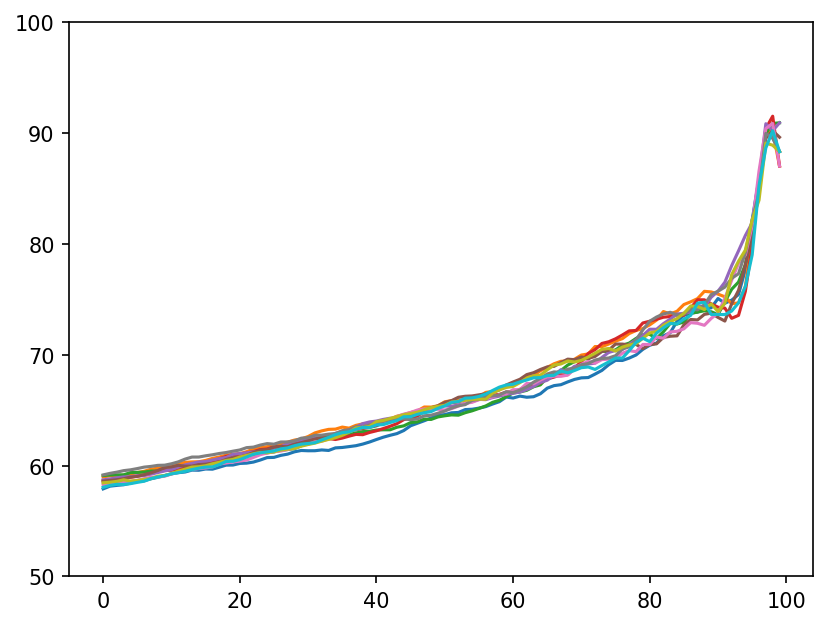

Training Members: ['0181', '0191', '0201', '0211', '0221', '0231', '0241']
loading data & saving
0
236/236 [==============================] - 0s 1ms/step
1
236/236 [==============================] - 0s 1ms/step
2
236/236 [==============================] - 0s 1ms/step
3
236/236 [==============================] - 0s 1ms/step
4
236/236 [==============================] - 0s 1ms/step
5
236/236 [==============================] - 0s 1ms/step
6
236/236 [==============================] - 0s 1ms/step
7
236/236 [==============================] - 0s 1ms/step
8
236/236 [==============================] - 0s 1ms/step
9
236/236 [==============================] - 0s 1ms/step


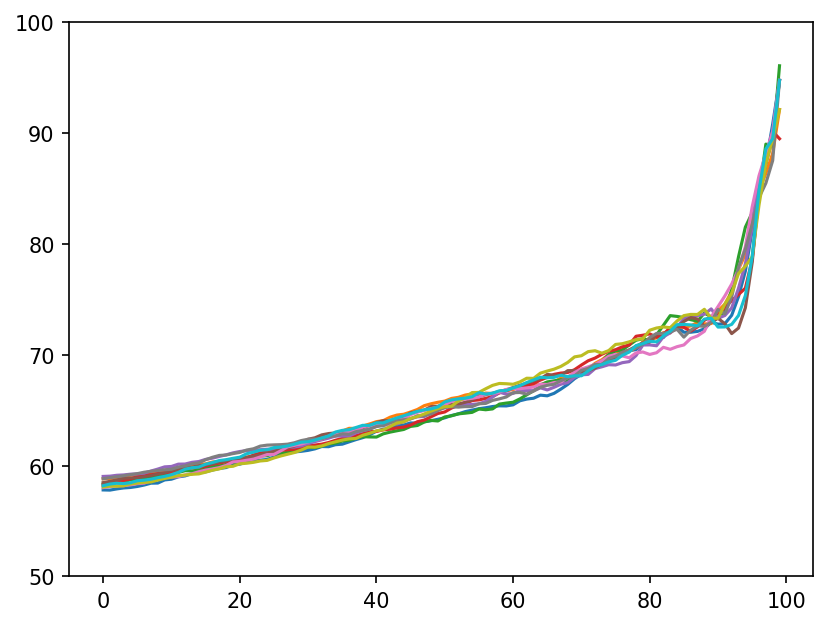

Training Members: ['0181', '0191', '0201', '0211', '0221', '0231', '0241', '0251']
loading data & saving
0
241/241 [==============================] - 0s 1ms/step
1
241/241 [==============================] - 0s 1ms/step
2
241/241 [==============================] - 0s 1ms/step
3
241/241 [==============================] - 0s 1ms/step
4
241/241 [==============================] - 0s 1ms/step
5
241/241 [==============================] - 0s 1ms/step
6
241/241 [==============================] - 0s 1ms/step
7
241/241 [==============================] - 0s 1ms/step
8
241/241 [==============================] - 0s 1ms/step
9
241/241 [==============================] - 0s 1ms/step


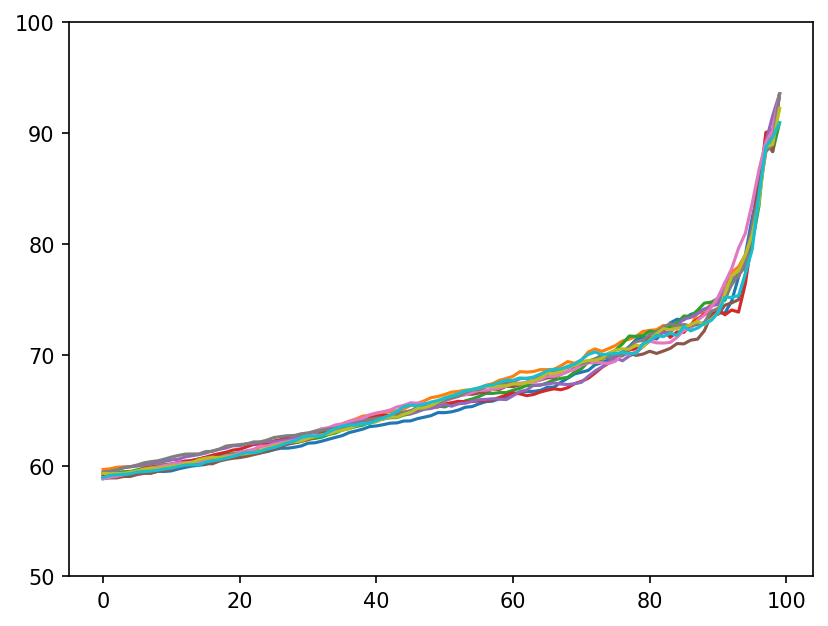

Training Members: ['0181', '0191', '0201', '0211', '0221', '0231', '0241', '0251', '0261']
loading data & saving
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 1ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 1ms/step
6
240/240 [==============================] - 0s 1ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 0s 1ms/step
9
240/240 [==============================] - 0s 1ms/step


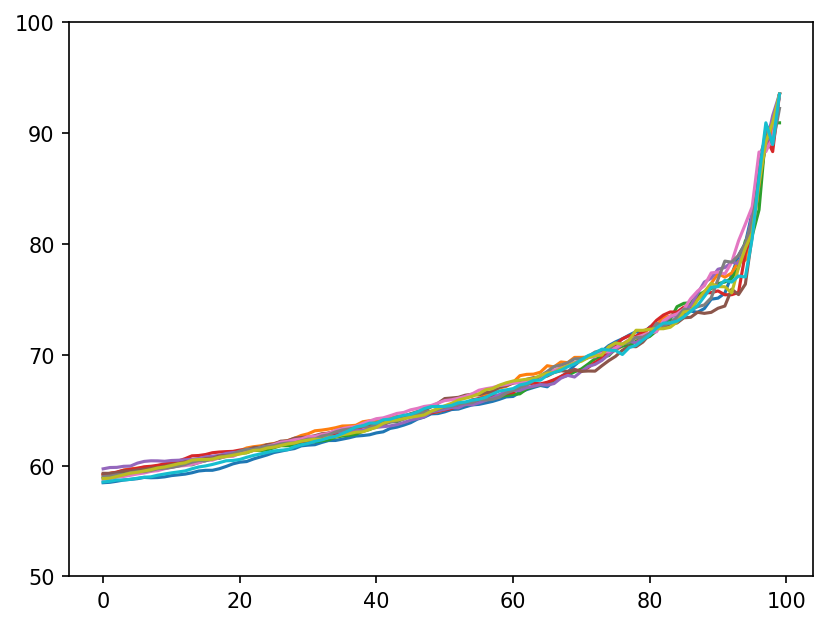

Validation Member: 0281
Testing Member: 0291
Training Members: ['0191']
loading data & saving
made it!
0
241/241 [==============================] - 0s 1ms/step
1
241/241 [==============================] - 0s 1ms/step
2
241/241 [==============================] - 0s 1ms/step
3
241/241 [==============================] - 0s 1ms/step
4
241/241 [==============================] - 0s 1ms/step
5
241/241 [==============================] - 0s 1ms/step
6
241/241 [==============================] - 0s 1ms/step
7
241/241 [==============================] - 0s 1ms/step
8
241/241 [==============================] - 0s 1ms/step
9
241/241 [==============================] - 0s 1ms/step


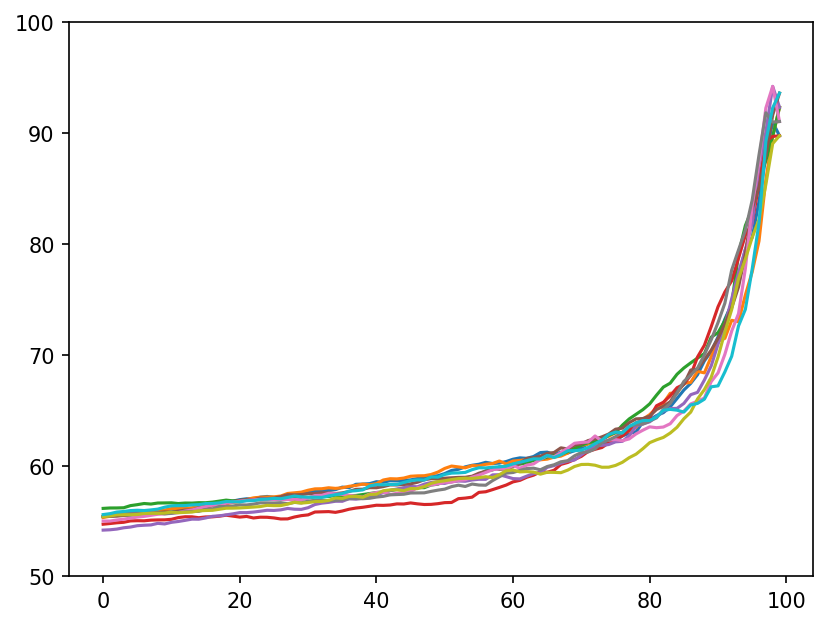

Training Members: ['0191', '0201']
loading data & saving
0
234/234 [==============================] - 0s 1ms/step
1
234/234 [==============================] - 0s 1ms/step
2
234/234 [==============================] - 1s 2ms/step
3
234/234 [==============================] - 1s 2ms/step
4
234/234 [==============================] - 0s 1ms/step
5
234/234 [==============================] - 0s 1ms/step
6
234/234 [==============================] - 0s 1ms/step
7
234/234 [==============================] - 0s 1ms/step
8
234/234 [==============================] - 0s 1ms/step
9
234/234 [==============================] - 0s 1ms/step


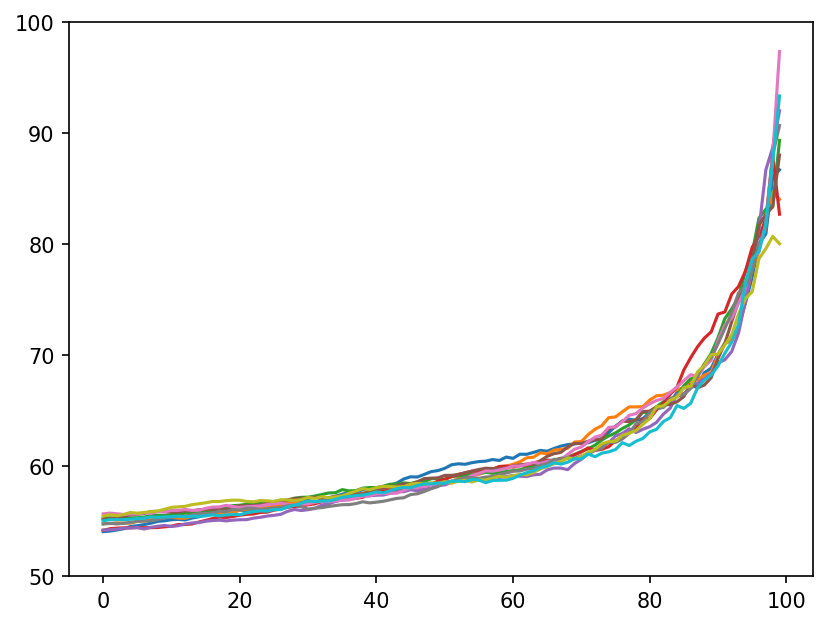

Training Members: ['0191', '0201', '0211']
loading data & saving
0
237/237 [==============================] - 0s 1ms/step
1
237/237 [==============================] - 0s 1ms/step
2
237/237 [==============================] - 0s 1ms/step
3
237/237 [==============================] - 0s 1ms/step
4
237/237 [==============================] - 0s 1ms/step
5
237/237 [==============================] - 0s 1ms/step
6
237/237 [==============================] - 0s 1ms/step
7
237/237 [==============================] - 0s 1ms/step
8
237/237 [==============================] - 0s 1ms/step
9
237/237 [==============================] - 0s 1ms/step


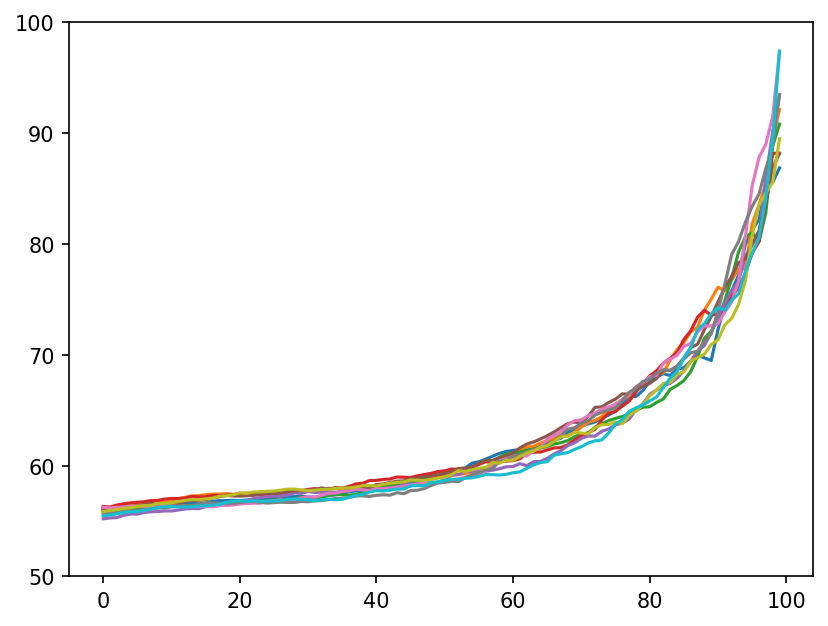

Training Members: ['0191', '0201', '0211', '0221']
loading data & saving
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 1ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 2ms/step
6
240/240 [==============================] - 1s 2ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 0s 1ms/step
9
240/240 [==============================] - 0s 1ms/step


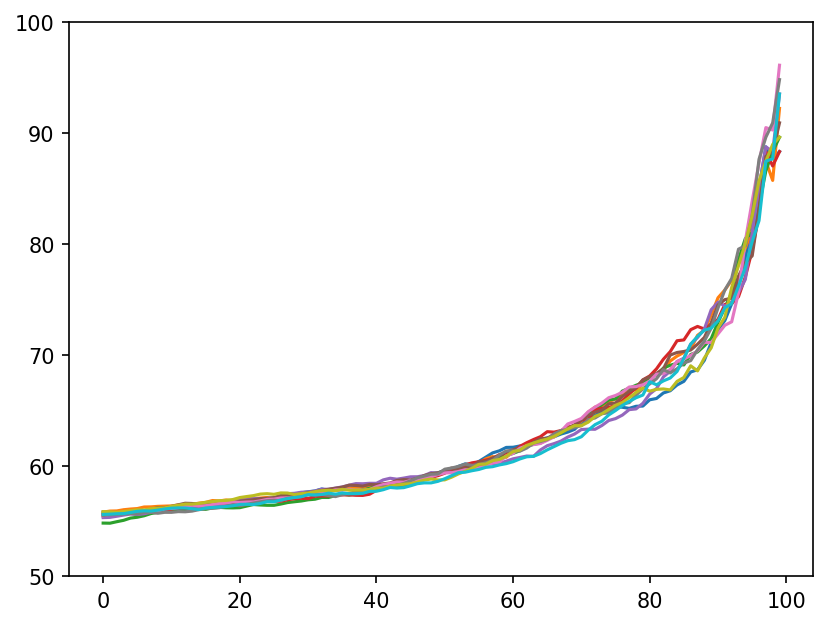

Training Members: ['0191', '0201', '0211', '0221', '0231']
loading data & saving
0
240/240 [==============================] - 0s 1ms/step
1
240/240 [==============================] - 0s 1ms/step
2
240/240 [==============================] - 0s 1ms/step
3
240/240 [==============================] - 0s 1ms/step
4
240/240 [==============================] - 0s 1ms/step
5
240/240 [==============================] - 0s 1ms/step
6
240/240 [==============================] - 0s 1ms/step
7
240/240 [==============================] - 0s 1ms/step
8
240/240 [==============================] - 0s 1ms/step
9
240/240 [==============================] - 0s 1ms/step


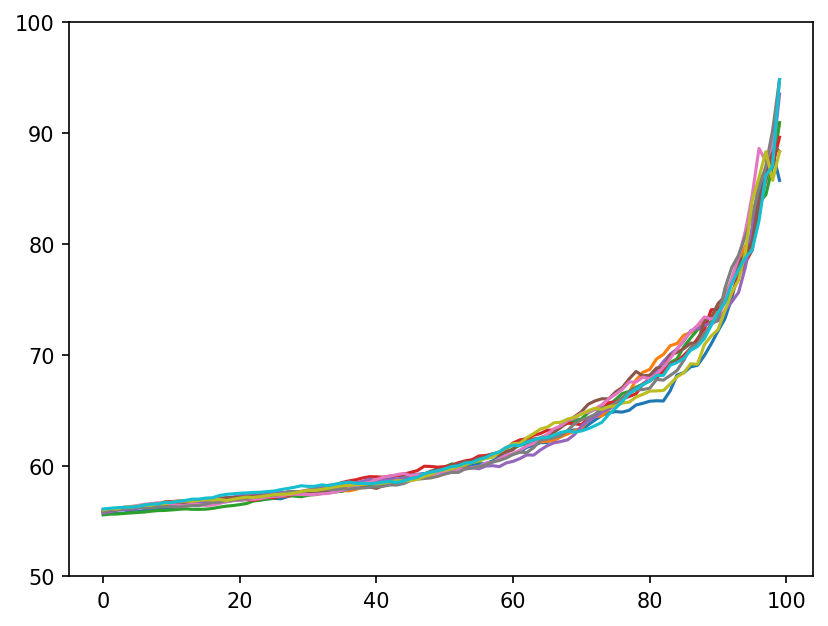

Training Members: ['0191', '0201', '0211', '0221', '0231', '0241']
loading data & saving
0
238/238 [==============================] - 0s 1ms/step
1
238/238 [==============================] - 0s 1ms/step
2
238/238 [==============================] - 0s 1ms/step
3
238/238 [==============================] - 0s 1ms/step
4
238/238 [==============================] - 0s 1ms/step
5
238/238 [==============================] - 0s 1ms/step
6
238/238 [==============================] - 0s 1ms/step
7
238/238 [==============================] - 0s 1ms/step
8
238/238 [==============================] - 0s 1ms/step
9
238/238 [==============================] - 0s 1ms/step


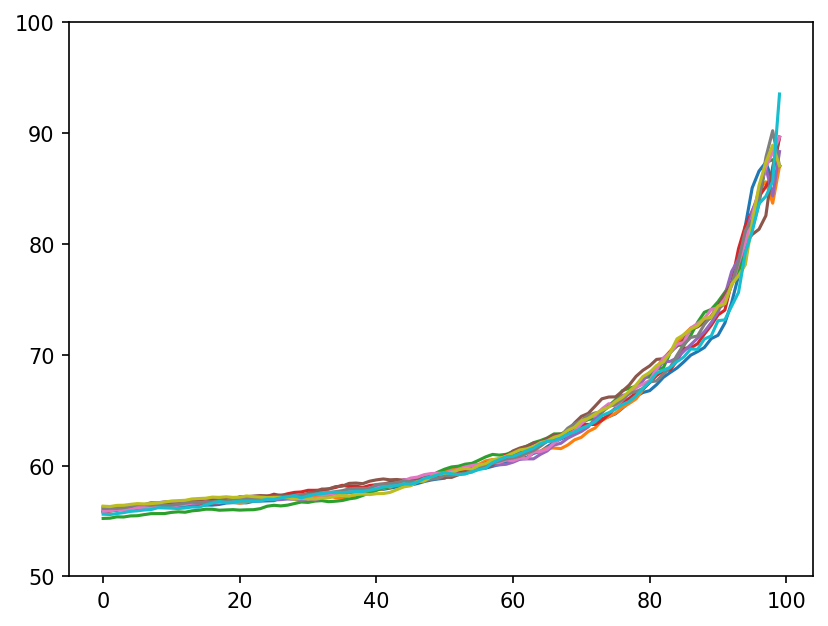

Training Members: ['0191', '0201', '0211', '0221', '0231', '0241', '0251']
loading data & saving
0
243/243 [==============================] - 0s 1ms/step
1
243/243 [==============================] - 0s 1ms/step
2
243/243 [==============================] - 0s 1ms/step
3
243/243 [==============================] - 0s 1ms/step
4
243/243 [==============================] - 0s 1ms/step
5
243/243 [==============================] - 0s 1ms/step
6
243/243 [==============================] - 0s 1ms/step
7
243/243 [==============================] - 0s 1ms/step
8
243/243 [==============================] - 0s 1ms/step
9
243/243 [==============================] - 0s 1ms/step


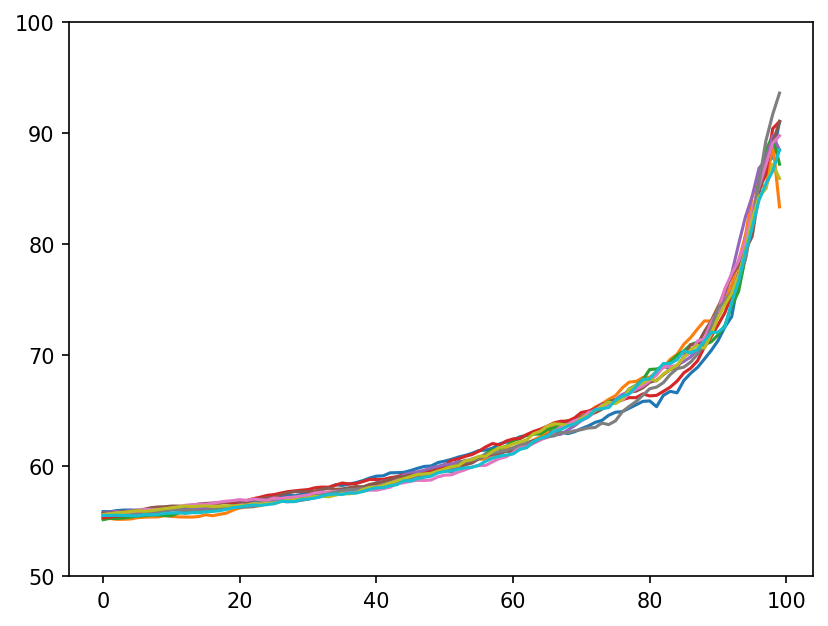

Training Members: ['0191', '0201', '0211', '0221', '0231', '0241', '0251', '0261']
loading data & saving
0
243/243 [==============================] - 0s 1ms/step
1
243/243 [==============================] - 0s 1ms/step
2
243/243 [==============================] - 0s 1ms/step
3
243/243 [==============================] - 0s 2ms/step
4
243/243 [==============================] - 0s 1ms/step
5
243/243 [==============================] - 0s 1ms/step
6
243/243 [==============================] - 0s 1ms/step
7
243/243 [==============================] - 0s 1ms/step
8
243/243 [==============================] - 0s 1ms/step
9
243/243 [==============================] - 0s 1ms/step


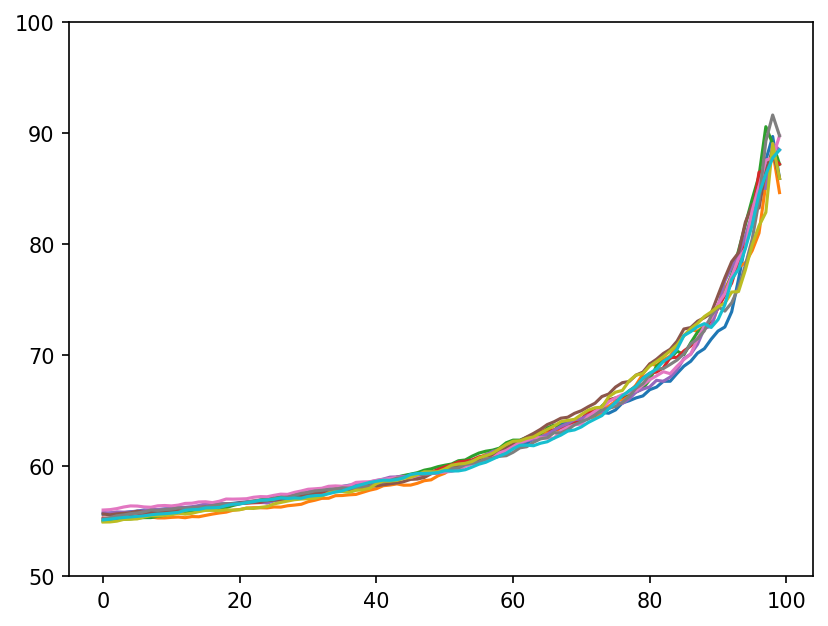

Training Members: ['0191', '0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271']
loading data & saving
0
243/243 [==============================] - 0s 742us/step
1
243/243 [==============================] - 0s 810us/step
2
243/243 [==============================] - 0s 736us/step
3
243/243 [==============================] - 0s 809us/step
4
243/243 [==============================] - 0s 1ms/step
5
243/243 [==============================] - 0s 1ms/step
6
243/243 [==============================] - 0s 741us/step
7
243/243 [==============================] - 0s 737us/step
8
243/243 [==============================] - 0s 748us/step
9
243/243 [==============================] - 0s 737us/step


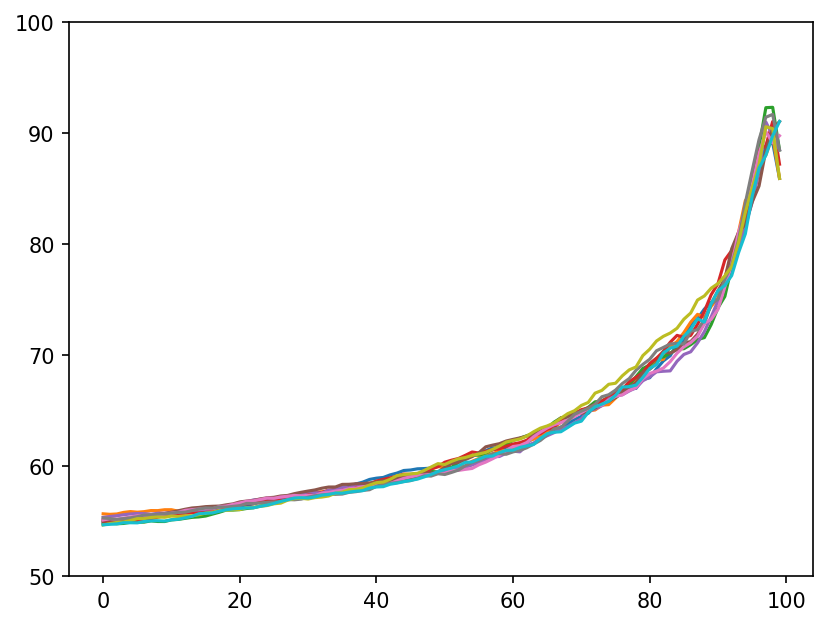

CPU times: user 7min 52s, sys: 1min 3s, total: 8min 56s
Wall time: 21min 22s


In [3]:
%%time
EXP_NAME = 'exp2_kfold'
EXP_NAME2 = 'exp2_retrain_increase_kfold'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

for kk in np.arange(16,20):
    print('Validation Member: '+str(hps2['val_mems'][kk][0]))
    print('Testing Member: '+str(hps2['test_mems'][kk][0]))
    
    for i_trainmems in range(9):
        print('Training Members: '+str(hps2['train_mems'][kk][i_trainmems]))
    
        _, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'][kk][i_trainmems],
                                                          valmem = hps2['val_mems'][kk][0],
                                                          testmem = hps2['test_mems'][kk][0],
                                                          months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                          lead = hps2['LEAD'])
    
        X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))
        
        
        #----- SET UP & TRAIN NN -----
        GLOBAL_SEED = hps['GLOBAL_SEED']
        np.random.seed(GLOBAL_SEED)
        random.seed(GLOBAL_SEED)
        tf.random.set_seed(GLOBAL_SEED)
    
        acc_all = []
        for SEED in range(10):
            print(SEED)
            annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
            ann = tf.keras.models.load_model(base_dir+'train/saved_models/kfold/'+annfi_name)
    
            pred = ann.predict(X1test)
            acc = []
            predconf = np.max(pred,axis=-1)
            predval  = np.argmax(pred,axis=-1)
    
            for q in range(100):
                iconf = np.where(predconf >= np.percentile(predconf,q=q))
                icorr = np.where(predval[iconf] == Y1test[iconf])
    
                acc.append((len(icorr[0])/len(iconf[0]))*100)
            plt.plot(acc)
            plt.ylim(50,100)
    
            acc_all.append(acc)
        plt.show()
        np.save(base_dir+'test/confvsacc/kfold/confvsacc_ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)